In [217]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import rotate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [235]:
def view_data(data: torch.Tensor, label: torch.Tensor, n: int) -> plt.Figure:
    
    arab_labs = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط' , 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى']

    fig, axs = plt.subplots(1, n, figsize=(21, 5))
    for i_ax, ax in enumerate(axs):
        ax.imshow(data[i_ax, :, :, :], cmap=plt.gray())
        ax.set_title("Label = %s" % (arab_labs[int(label[i_ax].item())]))
        ax.set_xticks([])
        ax.set_yticks([])
    return fig


def view_data_rand(loader: torch.utils.data.DataLoader, n: int = 10) -> plt.Figure:

    rand_data, rand_label = next(iter(loader))

    return view_data(rand_data, rand_label, n)

In [231]:
trainx = rotate(np.flip(
    pd.read_csv("../dataset/csvTrainImages 13440x1024.csv",
                header=None).values.astype('float32').reshape([-1, 32, 32, 1]),
    1),
                -90,
                axes=(1, 2))
trainy = pd.read_csv("../dataset/csvTrainLabel 13440x1.csv",
                     header=None).values.astype('int32') - 1

testx = rotate(np.flip(
    pd.read_csv("../dataset/csvTestImages 3360x1024.csv",
                header=None).values.astype('float32').reshape([-1, 32, 32, 1]),
    1),
               -90,
               axes=(1, 2))
testy = pd.read_csv("../dataset/csvTestLabel 3360x1.csv",
                    header=None).values.astype('int32') - 1

In [228]:
data_train = TensorDataset(torch.Tensor(trainx), torch.Tensor(trainy))

train_loader = DataLoader(data_train, batch_size=100, shuffle=True)

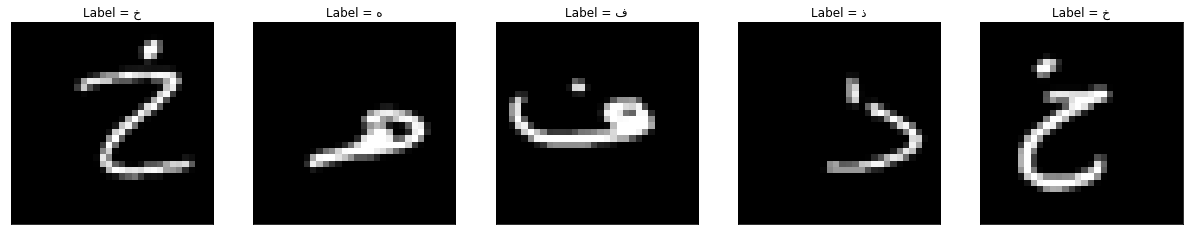

In [236]:
plts = view_data_rand(train_loader, n=5)